In [1]:
import torch
import torch.nn as nn
import torch.optim as opts
import numpy as np

from tensorflow.keras import datasets as dts
from torch_modules import commons as commons
from torch_modules.training import GANTrainer, callbacks, data

In [2]:
(x_train, _), _ = dts.fashion_mnist.load_data()

In [3]:
batch_size = 32

In [4]:
class Data(data.GanSequence):
    
    def get_len(self):
        return x_train.shape[0] // batch_size
    
    def get_item(self, idx):
        return x_train[idx * batch_size:(idx + 1) * batch_size, None, ...] / 127.5 - 1
    
    def shuffle(self):
        global x_train
        idc = np.random.choice(x_train.shape[0], size=x_train.shape[0], replace=False)
        x_train = x_train[idc]

In [5]:
d = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2),
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2),
    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2),
    commons.Reshape(7 * 7 * 256),
    nn.Linear(7 * 7 * 256, 1),
    nn.Sigmoid()
).cuda(0)

In [6]:
class Generator(nn.Sequential):
    
    def forward(self, x=None):
        x = x or torch.randn(32, 128, device="cuda:0")
        
        return super().forward(x)

g = Generator(
    nn.Linear(128, 7 * 7 * 256),
    nn.BatchNorm1d(7 * 7 * 256),
    nn.ReLU(),
    commons.Reshape(256, 7, 7),
    nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 1, 1),
    nn.Tanh()
).cuda(0)

In [7]:
d_opt = opts.Adam(d.parameters(), lr=2E-4, betas=(0.5, 0.999))
g_opt = opts.Adam(g.parameters(), lr=2E-4, betas=(0.5, 0.999))

In [8]:
cbs = [callbacks.GenImage(render_steps=50)]

In [9]:
from tqdm import tqdm_notebook as tqdm

In [10]:
train = Data(x_device="cuda:0")

In [11]:
loss = nn.BCELoss()

In [12]:
trainer = GANTrainer(d, g, d_opt, g_opt, loss)

1/100


W:\Anaconda3\envs\research\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


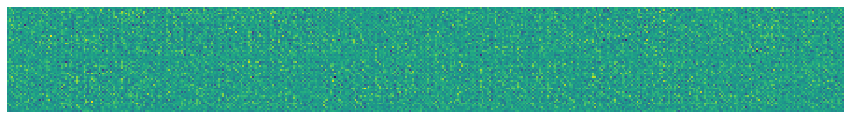

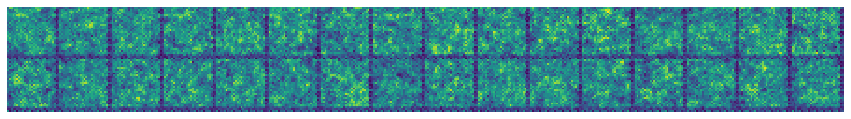

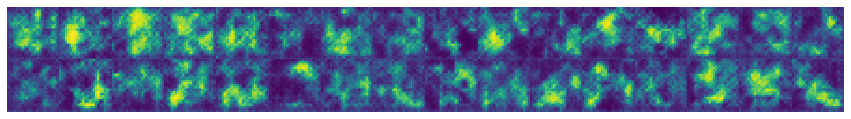

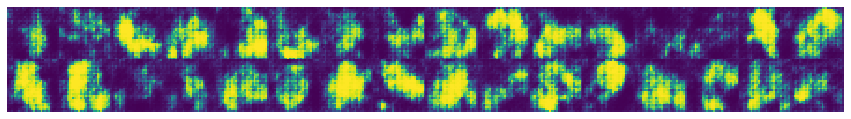

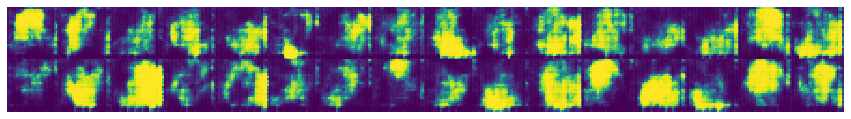

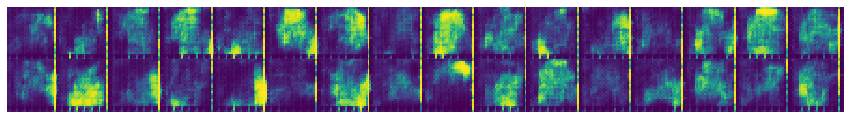

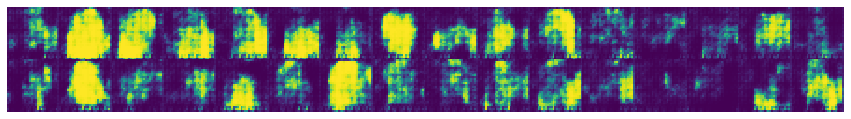

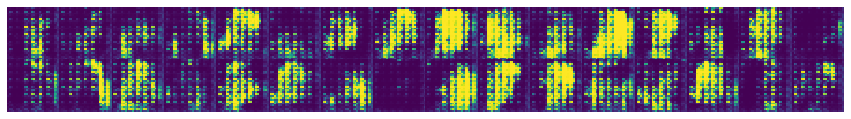

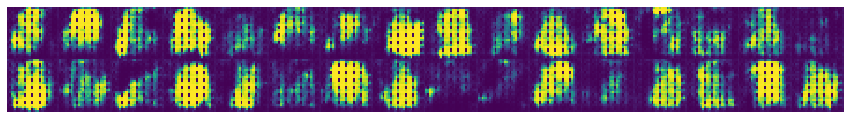

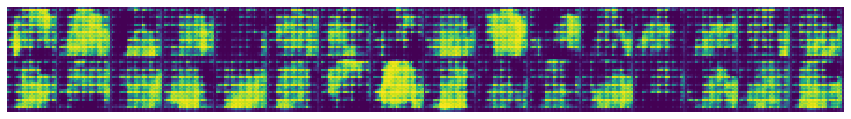

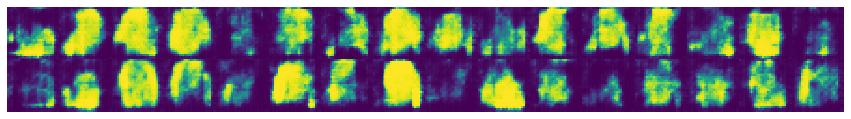

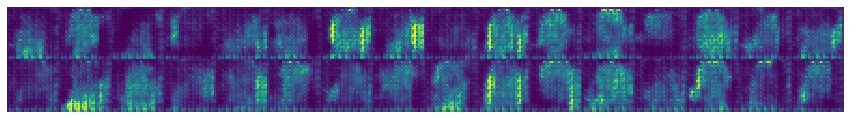

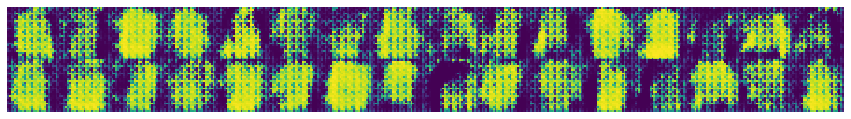

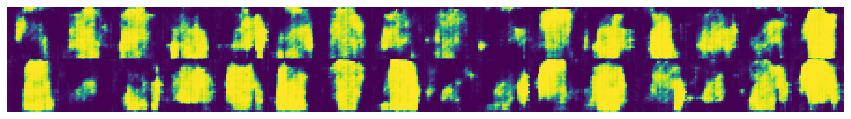

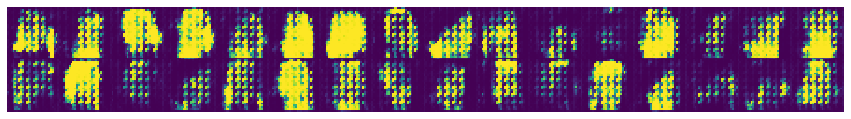

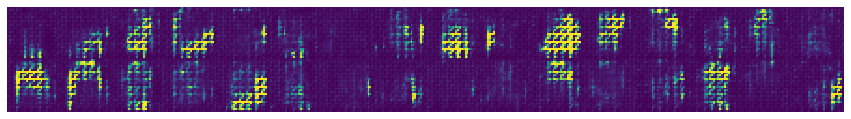

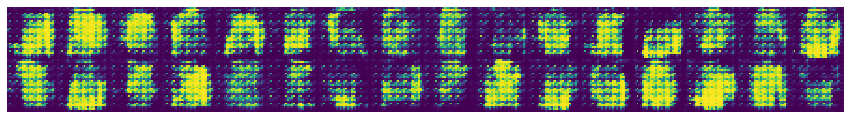

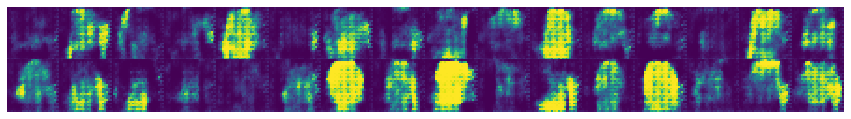

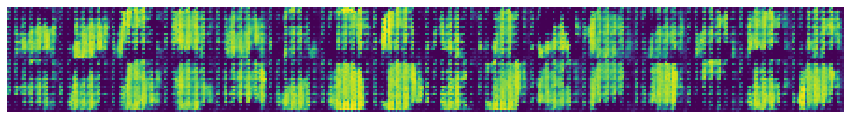

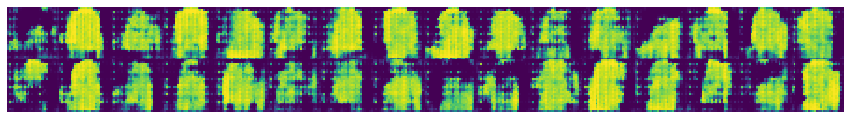

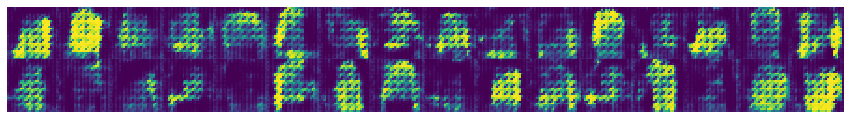

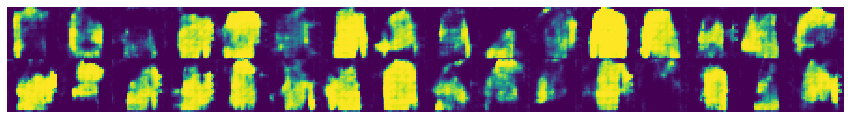

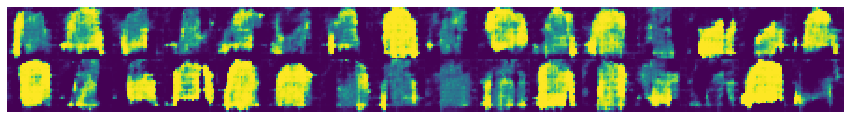

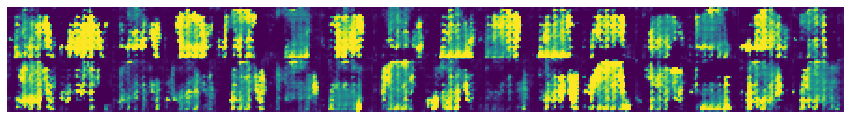

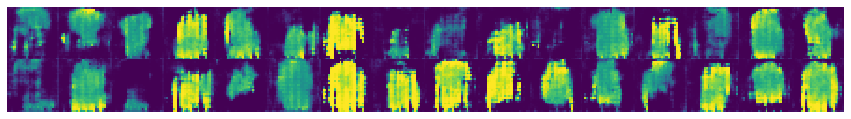

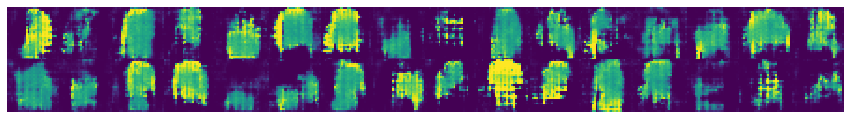

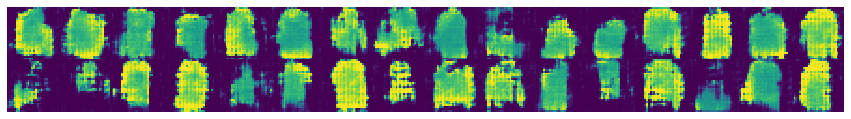

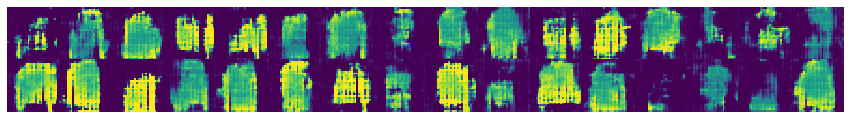

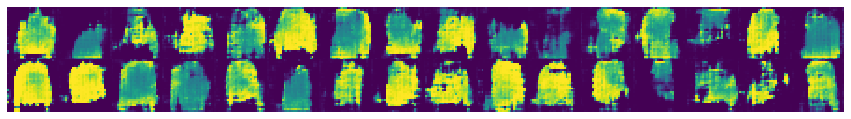

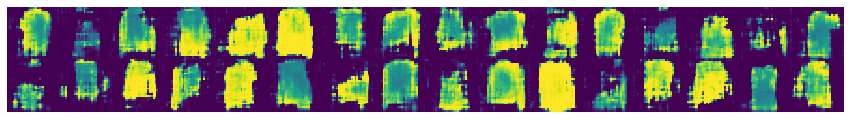

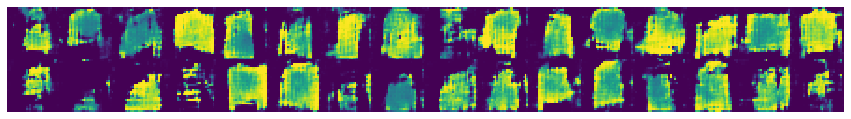

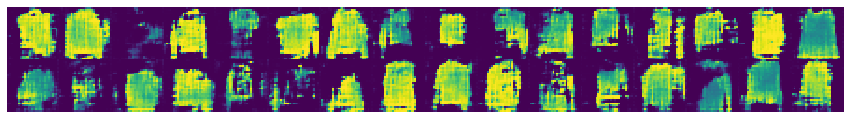

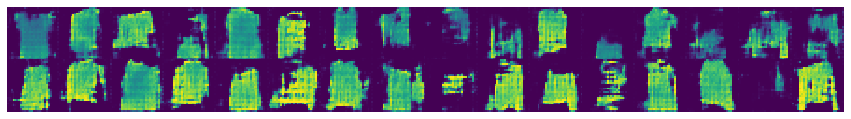

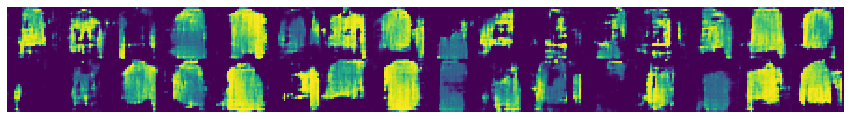

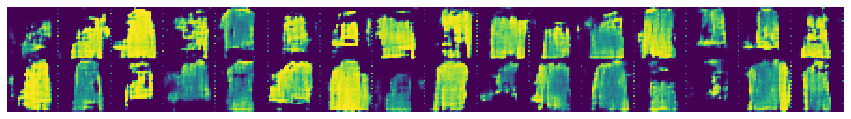

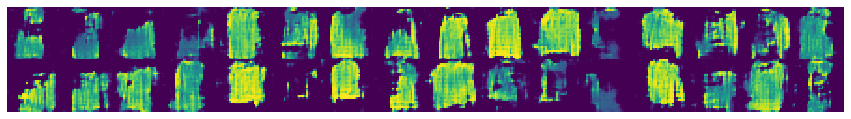

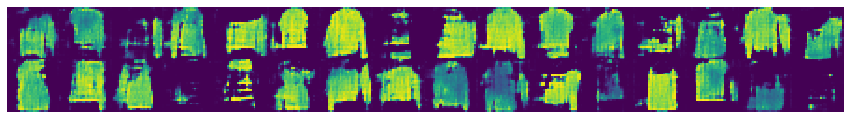

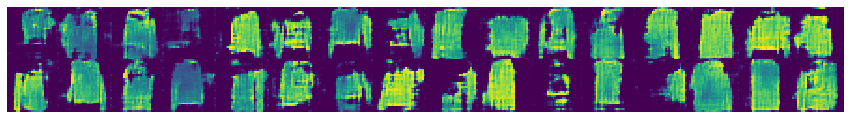

Lossy conversion from float32 to uint8. Range [-1.0, 0.9972937703132629]. Convert image to uint8 prior to saving to suppress this warning.


2/100


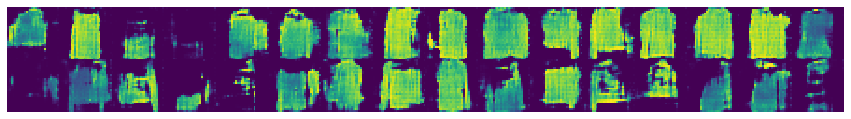

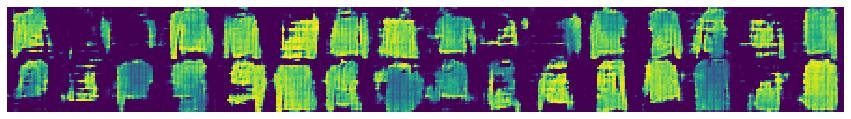

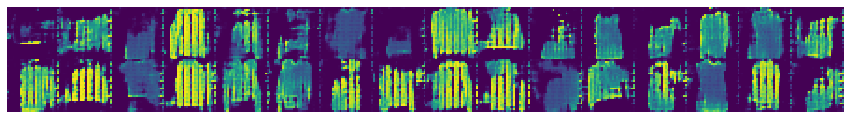

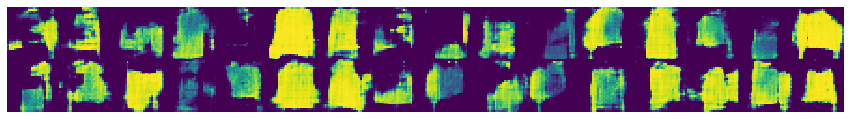

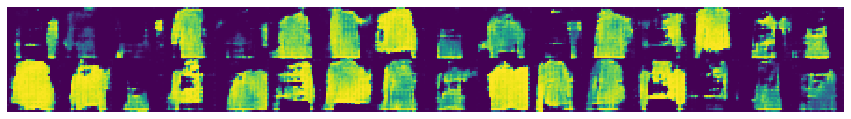

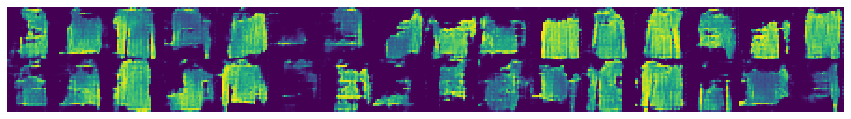

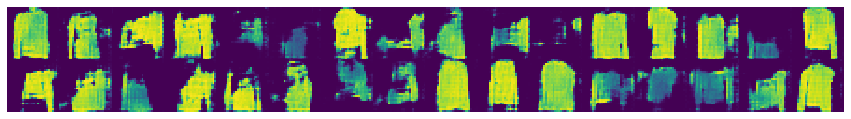

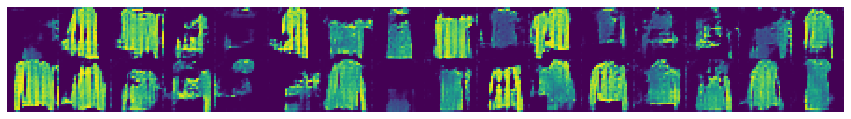

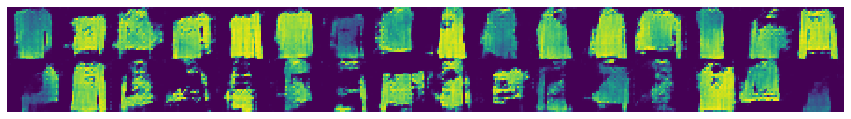

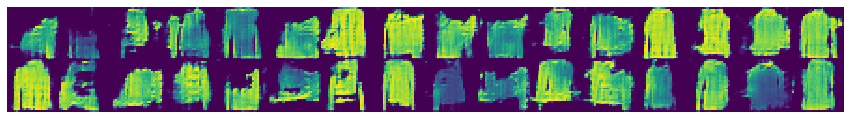

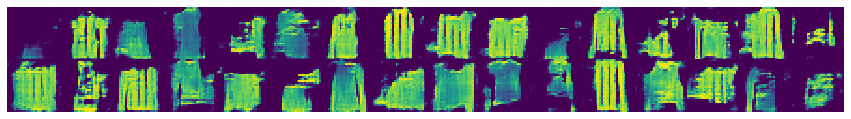

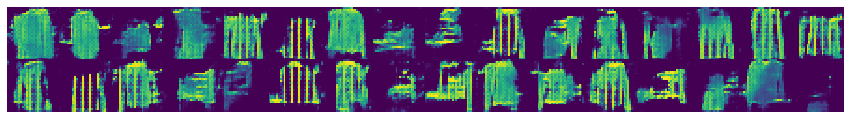

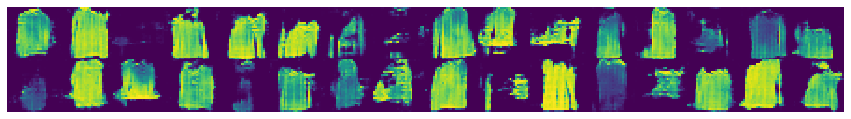

KeyboardInterrupt: 

In [13]:
trainer.fit(train, epochs=100, callbacks=cbs, pbar=tqdm)